In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing

Problem Overview

This dataset delves into the problem of illegal transactions involved in money laundering. 
The tricky part of using machine learning models is despite technological advances within the field, the rate of either false positive or false negatives are still relatively high. In the context of this issues, there could be many accounts involved in legitimate transactions to be flagged as illegally laundering and vice versa. 

In [2]:
from dask import dataframe as dd

In [7]:
df = dd.read_csv('HI-Large_Trans.csv')

In [8]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/08/01 00:17,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022/08/01 00:02,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022/08/01 00:17,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0
3,2022/08/01 00:03,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0
4,2022/08/01 00:02,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0


In [11]:
df.columns.tolist()

['Timestamp',
 'From Bank',
 'Account',
 'To Bank',
 'Account.1',
 'Amount Received',
 'Receiving Currency',
 'Amount Paid',
 'Payment Currency',
 'Payment Format',
 'Is Laundering']

In [11]:
df.npartitions

266

In [13]:

from matplotlib.ticker import FuncFormatter

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265


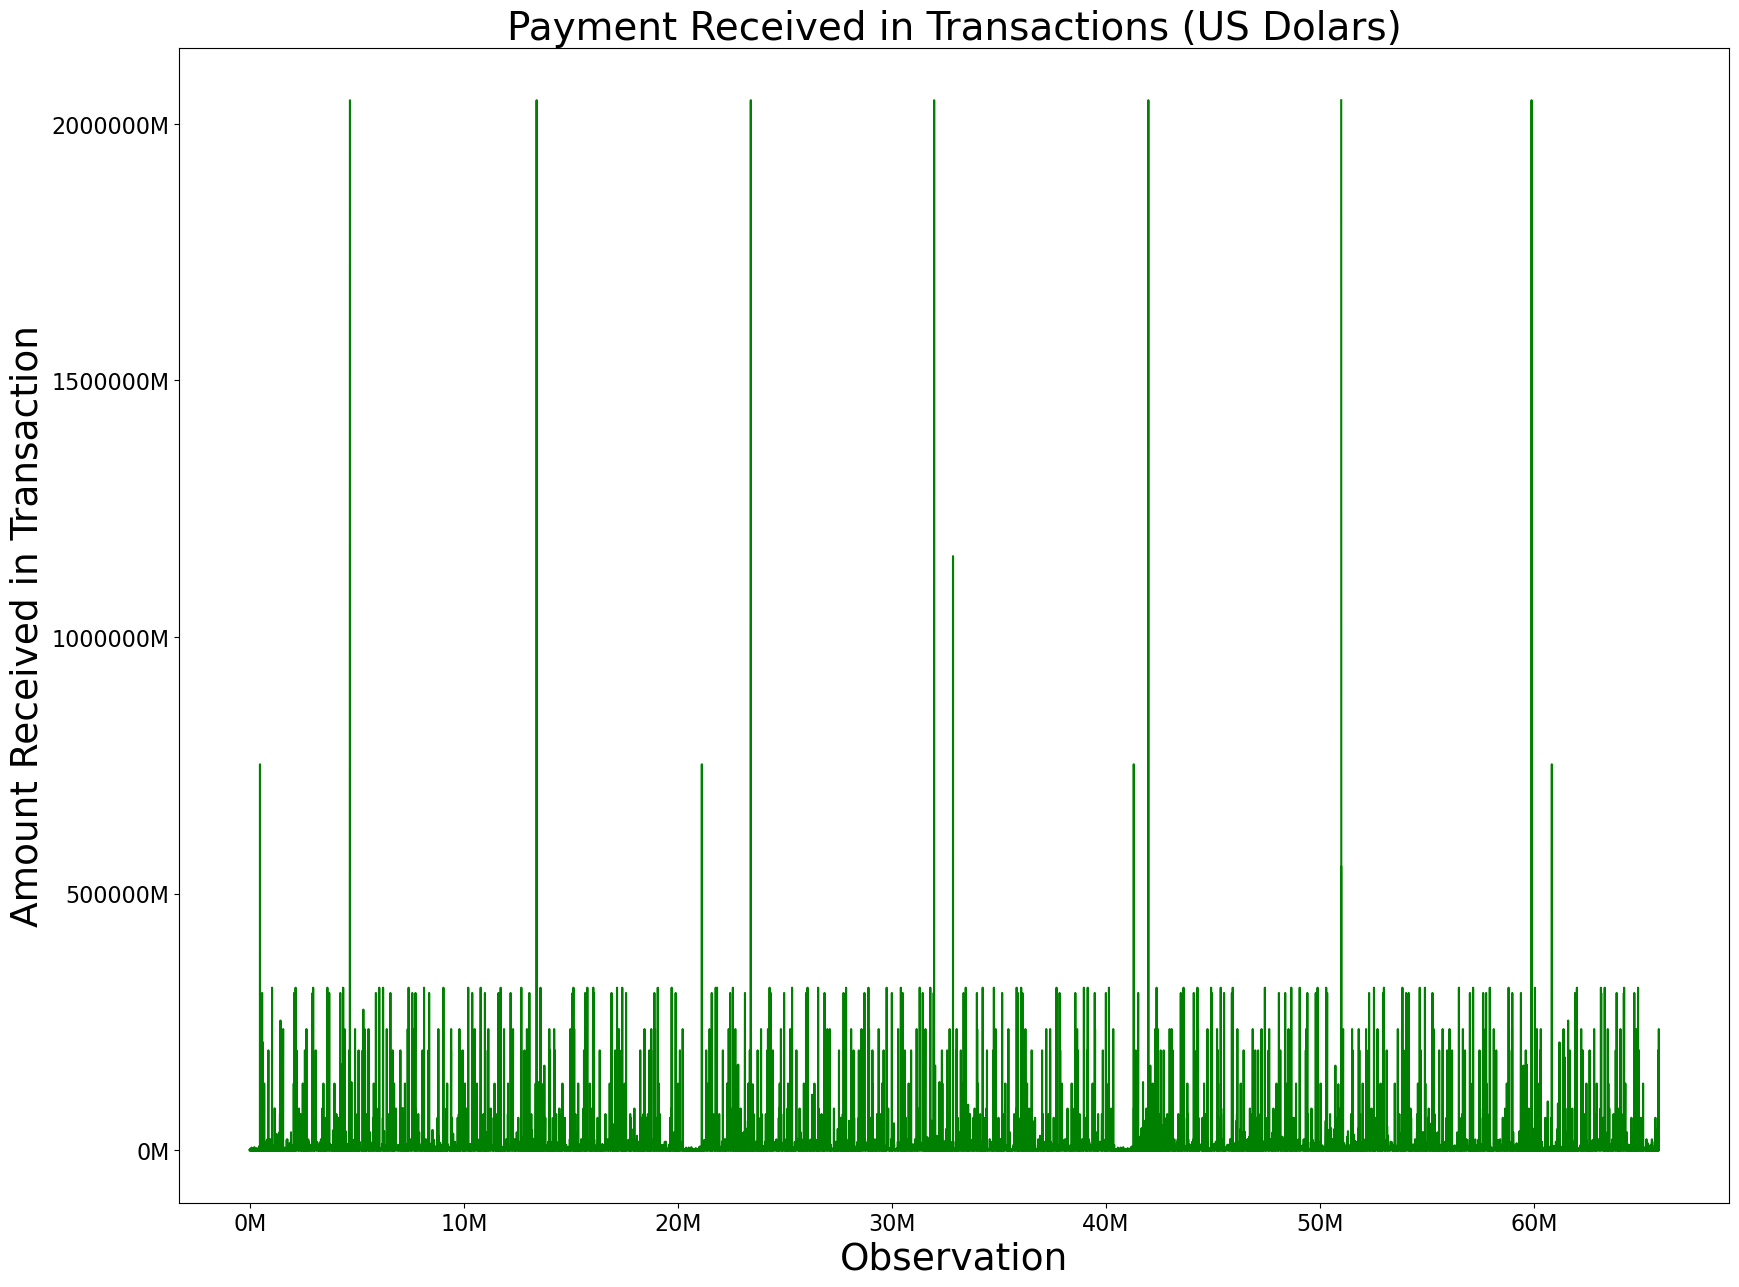

In [14]:
plt.figure(figsize=(20,15))
plt.xlabel("Observation", fontsize=27)
plt.ylabel("Amount Received in Transaction", fontsize = 27)

plt.title("Payment Received in Transactions (US Dolars)", fontsize = 28)


def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'


# Apply the formatter to the x-axis ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

length = 0
next_length = 0

for i in range(df.npartitions):
    df_temp = df.get_partition(i).compute()

    iter_length = len(df_temp[df_temp["Payment Currency"] == "US Dollar"]["Amount Received"])
    next_length += iter_length
    plt.plot(range(length, next_length), df_temp[df_temp["Payment Currency"] == "US Dollar"]["Amount Received"], color = "Green")
    length +=  iter_length
    print(i)


In [4]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

drop_columns = ["Timestamp", "Account", "Account.1", "Is Laundering"]

def keep_num_columns(df, oversample = False):
    LE = LabelEncoder()
    df["Payment Currency"] = LE.fit_transform( df["Payment Currency"])
    df["Receiving Currency"] = LE.fit_transform( df["Receiving Currency"])
    df["Payment Format"] = LE.fit_transform( df["Payment Format"])
    X = df.copy()
    X = X.drop(columns=drop_columns)
    Y = df.loc[:, "Is Laundering"]

    if oversample:
        ros = RandomOverSampler()
        X,Y = ros.fit_resample(X,Y)


    return X, Y


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

LR = LinearRegression()
DT = DecisionTreeClassifier()
RD = RandomForestClassifier()


In [15]:
partition265 = df.get_partition(265).compute()
from sklearn.linear_model import SGDClassifier

In [97]:
from sklearn.metrics import classification_report

Xtrain, Ytrain = keep_num_columns(df_6, oversample=False)


In [71]:
Xtest, Ytest = keep_num_columns(partition265, oversample=False)
SGD = SGDClassifier()

In [98]:
SGD.partial_fit(Xtrain, Ytrain, classes=range(2))

SGDClassifier()

In [62]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()

DT.fit(Xtrain, Ytrain)

DecisionTreeClassifier()

In [99]:
prediction = SGD.predict(Xtest)

In [100]:
from sklearn.metrics import classification_report

print(classification_report(Ytest, prediction))

c:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    677210
           1       0.00      0.00      0.00      2377

    accuracy                           1.00    679587
   macro avg       0.50      0.50      0.50    679587
weighted avg       0.99      1.00      0.99    679587



c:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Andy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
pd.DataFrame(prediction).value_counts()

0    679587
dtype: int64